In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
def features_choices_15(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench['lat']=bench['loc'].apply(lambda r:r.split('\'')[3]).astype('float')
    bench['lon']=bench['loc'].apply(lambda r:r.split('\'')[7]).astype('float')
    bench['adress']=bench['loc'].apply(lambda r:r.split('\'')[11].split(',')[0].split("\"")[3])
    bench = bench.drop(columns=['loc'])
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [6]:
def features_choices_16(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [7]:
def features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var):
    bench15_info, bench15_model = features_choices_15(bench15_0, to_drop_15, new_names_15, info_var, model_var)
    bench16_info, bench16_model = features_choices_16(bench16_0, to_drop_16, new_names_16, info_var, model_var)
    bench_info = pd.concat([bench15_info, bench16_info],axis=0)
    bench_info = bench_info.drop_duplicates(subset = ["id"]).reset_index(drop=True)
    bench_model = pd.concat([bench15_model, bench16_model],axis=0)
    bench_model = bench_model.drop_duplicates(subset = ["id"]).reset_index(drop=True)    
    return bench_info, bench_model

In [8]:
def boxplot(x):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.boxplot(x, vert = False)
    plt.show()

In [9]:
def cleansing_and_imputation(bench_model):
    to_complete_cat = ['lput', 'sput', 'tput']
    for cat in to_complete_cat:
        bench_model[cat] = bench_model[cat].fillna('Aucun')
        bench_model[cat+'_gfa'] = bench_model[cat+'_gfa'].fillna(0)
    drop_idx = bench_model[(bench_model['energy_use'].isna())|(bench_model['ghg_emission'].isna())|(bench_model["nf"].isna())|(bench_model["total_gfa"]<0)].index
    bench_model = bench_model.drop(drop_idx)
    bench_model = bench_model.sort_values(by='id')
    return bench_model

In [34]:
def impute_lput():
    unchanged = ["Hotel","Retail Store","Non-Refrigerated Warehouse","Other","Distribution Center","Medical Office","Worship Facility","Laboratory","Refrigerated Warehouse","Supermarket/Grocery Store", "Restaurant", "College/University","Senior Care Community","Self-Storage Facility"]
    for idx in bench_model[(~bench_model["primary_type"].isna())&(bench_model["lput"].isna())].index:
        if (bench_model.loc[idx,"primary_type"]=="Large Office")|(bench_model.loc[idx,"primary_type"]=="Small- and Mid-Sized Office"):
            bench_model.at[idx,"lput"] = "Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]    
        if "Multifamily" in bench_model.loc[idx,"primary_type"]:
            bench_model.at[idx,"lput"] = "Multifamily Housing"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if (bench_model.loc[idx,"primary_type"]=="SPS-District K-12"):
            bench_model.at[idx,"lput"] = "K-12 School"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 
        if (bench_model.loc[idx,"primary_type"]=="Hospital"):
            bench_model.at[idx,"lput"] = "Hospital (General Medical & Surgical)"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx in [649, 2262, 2716]:
            bench_model.at[idx,"lput"] = "Retail Store"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==347:
            bench_model.at[idx,"lput"] = "Medical Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==309:
            bench_model.at[idx,"lput"] = "Other"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if bench_model.loc[idx,"primary_type"] in unchanged:
            bench_model.at[idx,"lput"] = bench_model.loc[idx,"primary_type"]
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 

In [117]:
def compute_lput_2(lput):
    lput_2 = 'moderate_energy_use_lput'
    if lput in ['College/University', 'Hospital (General Medical & Surgical)', 'Data Center']:
        lput_2 = 'very_high_energy_use_lput'
    if lput in ['Convention Center','Courthouse','Urgent Care/Clinic/Other Outpatient', 'Laboratory', 'Other - Mall','Parking', 'Other - Entertainment/Public Assembly', 'Lifestyle Center', 'Wholesale Club/Supercenter', 'Medical Office', 'Police Station', 'Hotel', 'Other']:
        lput_2 = 'high_energy_use_lput'
    if lput in ['Supermarket/Grocery Store', 'Office', 'Senior Care Community', 'Other - Restaurant/Bar', 'Restaurant', 'Museum', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital', 'Strip Mall', 'Library', 'Retail Store', 'Residence Hall/Dormitory', 'Other - Recreation', 'Other - Education', 'Manufacturing/Industrial Plant', 'K-12 School', 'Refrigerated Warehouse']:
        lput_2 = 'moderate_energy_use_lput'
    if lput in ['Movie Theater', 'Other - Services', 'Social/Meeting Hall', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Distribution Center', 'Automobile Dealership', 'Multifamily Housing', 'Adult Education', 'Other - Utility', 'Financial Office', 'Non-Refrigerated Warehouse', 'Other - Lodging/Residential', 'Performing Arts', 'Pre-school/Daycare', 'Bank Branch', 'Residential Care Facility', 'Worship Facility', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Public Services']:
        lput_2 = 'low_energy_use_lput'
    if lput in ['Prison/Incarceration', 'Self-Storage Facility', 'Outpatient Rehabilitation/Physical Therapy', 'Food Service']:
        lput_2 = 'very_low_energy_use_lput'   
    return lput_2

In [132]:
def compute_sput_2(sput):
    sput_2 = 'moderate_energy_use_sput'
    if sput in ['Data Center', 'Hospital (General Medical & Surgical)', 'Laboratory', 'Hotel', 'College/University', 'Other - Recreation', 'Courthouse', 'Other/Specialty Hospital']:
        sput_2 = 'very_high_energy_use_sput'
    if sput in ['Convenience Store without Gas Station', 'Movie Theater', 'Multifamily Housing', 'Supermarket/Grocery Store', 'Other - Entertainment/Public Assembly', 'Performing Arts', 'Other - Restaurant/Bar']:
        sput_2 = 'high_energy_use_sput'
    if sput in ['Parking', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Adult Education', 'Office', 'Other - Services', 'Restaurant', 'Senior Care Community', 'Manufacturing/Industrial Plant', 'Financial Office', 'Food Sales', 'Retail Store','Aucun']:
        sput_2 = 'moderate_energy_use_sput'
    if sput in ['Other - Public Services', 'Swimming Pool', 'Distribution Center', 'Other', 'Bar/Nightclub', 'Fitness Center/Health Club/Gym', 'Medical Office', 'Non-Refrigerated Warehouse', 'Food Service', 'Self-Storage Facility', 'Bank Branch', 'Worship Facility', 'Vocational School', 'Museum']:
        sput_2 = 'low_energy_use_sput'
    if sput in ['K-12 School', 'Other - Lodging/Residential', 'Other - Education', 'Refrigerated Warehouse', 'Residence Hall/Dormitory']:
        sput_2 = 'very_low_energy_use_sput'   
    return sput_2

In [159]:
def compute_tput_2(tput):
    tput_2 = 'moderate_energy_use_tput'
    if tput in ['Convenience Store without Gas Station', 'Worship Facility', 'Laboratory']:
        tput_2 = 'high_energy_use_tput'
    if tput in ['Fitness Center/Health Club/Gym', 'Data Center', 'Bank Branch', 'Other - Recreation', 'Other - Restaurant/Bar', 'Enclosed Mall', 'Refrigerated Warehouse', 'Supermarket/Grocery Store', 'Financial Office', 'Other', 'Residence Hall/Dormitory', 'K-12 School', 'Multifamily Housing', 'Food Sales', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Medical Office', 'Swimming Pool', 'Parking']:
        tput_2 = 'moderate_energy_use_tput'
    if tput in ['Manufacturing/Industrial Plant', 'Other - Lodging/Residential', 'College/University', 'Food Service', 'Restaurant', 'Other - Services', 'Distribution Center', 'Retail Store', 'Bar/Nightclub', 'Social/Meeting Hall', 'Office', 'Other - Entertainment/Public Assembly', 'Non-Refrigerated Warehouse', 'Strip Mall', 'Aucun', 'Other - Public Services', 'Self-Storage Facility', 'Fast Food Restaurant', 'Pre-school/Daycare', 'Other - Technology/Science']:
        tput_2 = 'low_energy_use_tput'  
    return tput_2

In [168]:
bench15_0 = pd.read_csv(r"2015-building-energy-benchmarking.csv")

In [169]:
bench16_0 = pd.read_csv(r"2016-building-energy-benchmarking.csv")

In [170]:
to_drop_15 = ["DataYear","YearBuilt",'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood','PropertyGFAParking','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)','DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats']

In [171]:
new_names_15 = {'OSEBuildingID':'id', 'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name','Location':'loc', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'GHGEmissions(MetricTonsCO2e)':'ghg_emission', 'Zip Codes':'zip'}

In [172]:
new_names_16 = {'OSEBuildingID':'id',  'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name', 'Address':'adress', 'ZipCode':'zip', 'Latitude':'lat', 'Longitude':'lon', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'TotalGHGEmissions':'ghg_emission'}

In [173]:
to_drop_16 = ['DataYear','City', 'State','TaxParcelIdentificationNumber','CouncilDistrictCode', 'Neighborhood','YearBuilt','PropertyGFAParking','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',  'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']

In [174]:
info_var = ['id', 'name', 'lat', 'lon', 'adress', 'energy_score', 'zip']

In [175]:
model_var = ['id', 'age', 'nb', 'nf', 'type', 'primary_type', 'building_gfa' ,'total_gfa', 'lput', 'lput_gfa', 'sput', 'sput_gfa', 'tput', 'tput_gfa', 'energy_score', 'energy_use', 'ghg_emission']

In [176]:
bench_info, bench_model = features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var)

In [177]:
bench_model = bench_model.drop(bench_model[(bench_model.lput_gfa>bench_model.total_gfa)|(bench_model.sput_gfa>bench_model.total_gfa)|(bench_model.tput_gfa>bench_model.total_gfa)].index)

In [178]:
impute_lput()

In [179]:
bench_model = bench_model.drop(bench_model[bench_model["energy_use"]>2*10**7].index)

In [180]:
bench_model['lput_2'] = bench_model['lput'].apply(compute_lput_2)

In [181]:
bench_model['sput_2'] = bench_model['sput'].apply(compute_sput_2)

In [182]:
bench_model['tput_2'] = bench_model['sput'].apply(compute_tput_2)

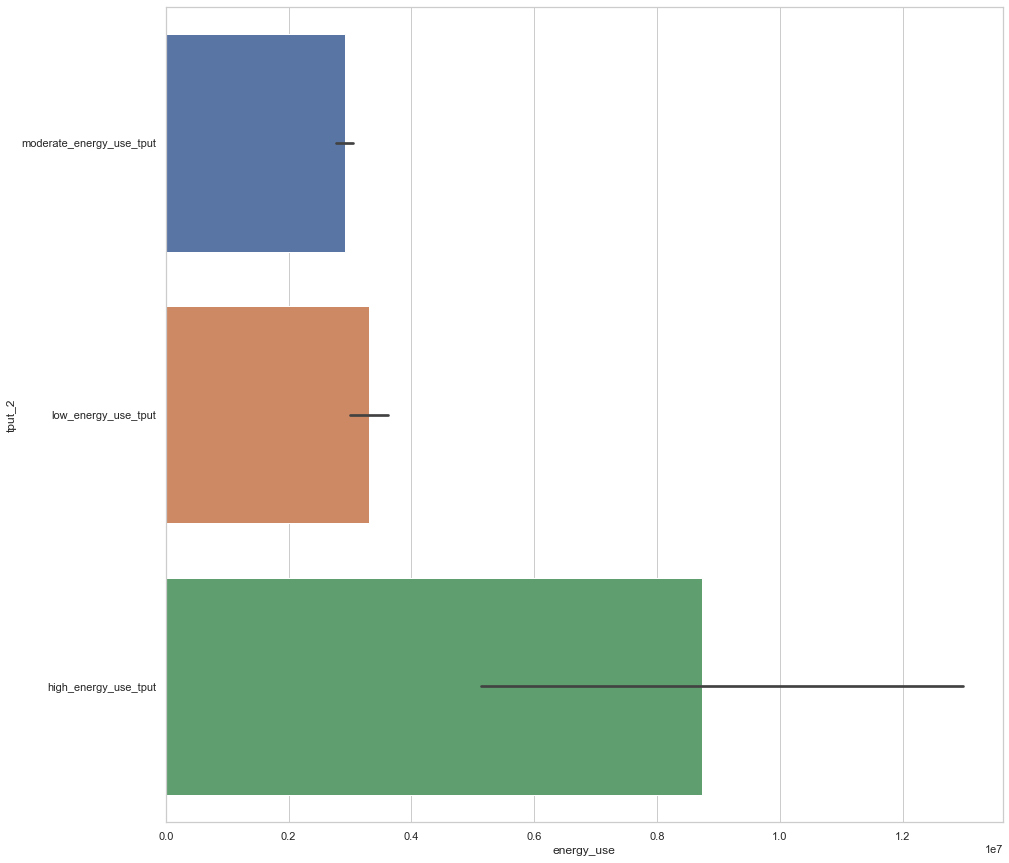

In [183]:
fig, ax = plt.subplots(figsize=(15,15))
sns.set_theme(style="whitegrid") 
ax = sns.barplot(x="energy_use", y="tput_2", data=bench_model)
# ax = sns.countplot(y='lput', data=)

In [184]:
bench_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 0 to 3431
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2991 non-null   int64  
 1   age           2991 non-null   int64  
 2   nb            2990 non-null   float64
 3   nf            2987 non-null   float64
 4   type          2991 non-null   object 
 5   primary_type  2991 non-null   object 
 6   building_gfa  2991 non-null   int64  
 7   total_gfa     2991 non-null   int64  
 8   lput          2991 non-null   object 
 9   lput_gfa      2991 non-null   float64
 10  sput          1413 non-null   object 
 11  sput_gfa      1413 non-null   float64
 12  tput          499 non-null    object 
 13  tput_gfa      499 non-null    float64
 14  energy_score  2303 non-null   float64
 15  energy_use    2982 non-null   float64
 16  ghg_emission  2981 non-null   float64
 17  lput_2        2991 non-null   object 
 18  sput_2        2991 non-null 

In [185]:
# print(list(bench_model.columns))

In [186]:
bench_model_cleaned = cleansing_and_imputation(bench_model)

In [187]:
bench_model_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2977 entries, 0 to 3431
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2977 non-null   int64  
 1   age           2977 non-null   int64  
 2   nb            2977 non-null   float64
 3   nf            2977 non-null   float64
 4   type          2977 non-null   object 
 5   primary_type  2977 non-null   object 
 6   building_gfa  2977 non-null   int64  
 7   total_gfa     2977 non-null   int64  
 8   lput          2977 non-null   object 
 9   lput_gfa      2977 non-null   float64
 10  sput          2977 non-null   object 
 11  sput_gfa      2977 non-null   float64
 12  tput          2977 non-null   object 
 13  tput_gfa      2977 non-null   float64
 14  energy_score  2302 non-null   float64
 15  energy_use    2977 non-null   float64
 16  ghg_emission  2977 non-null   float64
 17  lput_2        2977 non-null   object 
 18  sput_2        2977 non-null 

In [50]:
# boxplot(bench_model_cleaned["energy_use"])

In [188]:
bench_model_cleaned.to_excel("benchmark_cleaned_opt.xlsx", index=False)